In [51]:
import xml.etree.ElementTree as ET
import os

def extract_labels_from_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    labels = []
    for member in root.findall('object'):
        label = member.find('name').text
        bndbox = member.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        labels.append((label, (xmin, ymin, xmax, ymax)))
    return labels

xml_dir = r"C:\Users\전대혁\TEST_Lab\Data_file"
xml_files = [os.path.join(xml_dir, file) for file in os.listdir(xml_dir) if file.endswith('.xml')]

all_labels = []
for xml_file in xml_files:
    labels = extract_labels_from_xml(xml_file)
    all_labels.extend(labels)

print(all_labels)

[('apple', (307, 111, 358, 148)), ('apple', (500, 84, 563, 129)), ('apple', (533, 144, 589, 194)), ('apple', (439, 243, 492, 292)), ('apple', (623, 271, 680, 322)), ('apple', (455, 304, 513, 355)), ('apple', (331, 161, 386, 203)), ('apple', (856, 270, 919, 324)), ('apple', (870, 367, 929, 424)), ('apple', (843, 452, 901, 503)), ('apple', (846, 51, 890, 91)), ('apple', (650, 38, 705, 83)), ('apple', (65, 141, 119, 183)), ('apple', (43, 4, 93, 42)), ('apple', (106, 207, 159, 250)), ('apple', (600, 186, 646, 224)), ('apple', (659, 237, 719, 286)), ('apple', (804, 349, 858, 392)), ('apple', (332, 273, 366, 313)), ('apple', (500, 233, 543, 277)), ('apple', (510, 343, 553, 385)), ('apple', (804, 218, 858, 247)), ('apple', (444, 122, 477, 142)), ('apple', (446, 145, 473, 164)), ('apple', (443, 90, 465, 112)), ('apple', (364, 12, 418, 53)), ('apple', (221, 48, 270, 80)), ('apple', (684, 154, 739, 177)), ('apple', (159, 3, 205, 21)), ('apple', (300, 158, 332, 191)), ('apple', (35, 179, 64, 220)

In [52]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 이미지 파일 경로
image_path = r"..\TEST_Lab\Data_file\apple-1.jpg"

# 이미지 불러오기
image = cv2.imread(image_path)

# 라벨링 데이터 
labeling_data = all_labels

# 특징 추출 및 라벨링
features = []
labels_list = []
bounding_boxes = []
for label, (xmin, ymin, xmax, ymax) in labeling_data:
    roi = image[ymin:ymax, xmin:xmax]
    roi_resized = cv2.resize(roi, (32, 32)).flatten()
    features.append(roi_resized)
    labels_list.append(1 if label == "apple" else 0)  # 'apple'이면 1, 아니면 0
    bounding_boxes.append((xmin, ymin, xmax, ymax))

features = np.array(features)
labels = np.array(labels_list)


In [54]:
# 데이터 분할 및 정규화
X_train, X_test, y_train, y_test, boxes_train, boxes_test = train_test_split(
    features, labels, bounding_boxes, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [68]:
# 모델 정의
models = {
    "k-NN": KNeighborsClassifier(n_neighbors=3),
    "SVM": SVC(kernel='linear'),
    "Decision Tree": DecisionTreeClassifier(),
    "Ensemble (Random Forest)": RandomForestClassifier(n_estimators=100)
}

# 모델 학습 및 평가
results = {}
predictions = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    predictions[model_name] = y_pred
    

In [69]:
# 각 모델별 정확도 
for model_name, accuracy in results.items():
    print(f"{model_name} 정확도: {accuracy:.2f}")

k-NN 정확도: 0.74
SVM 정확도: 0.95
Decision Tree 정확도: 0.84
Ensemble (Random Forest) 정확도: 0.89


In [70]:
# 탐지된 사과 개수 출력
for model_name, y_pred in predictions.items():
    detected_apples = np.sum(y_pred == 1)
    print(f"{model_name} 탐지된 사과의 개수: {detected_apples}")

k-NN 탐지된 사과의 개수: 6
SVM 탐지된 사과의 개수: 10
Decision Tree 탐지된 사과의 개수: 10
Ensemble (Random Forest) 탐지된 사과의 개수: 9


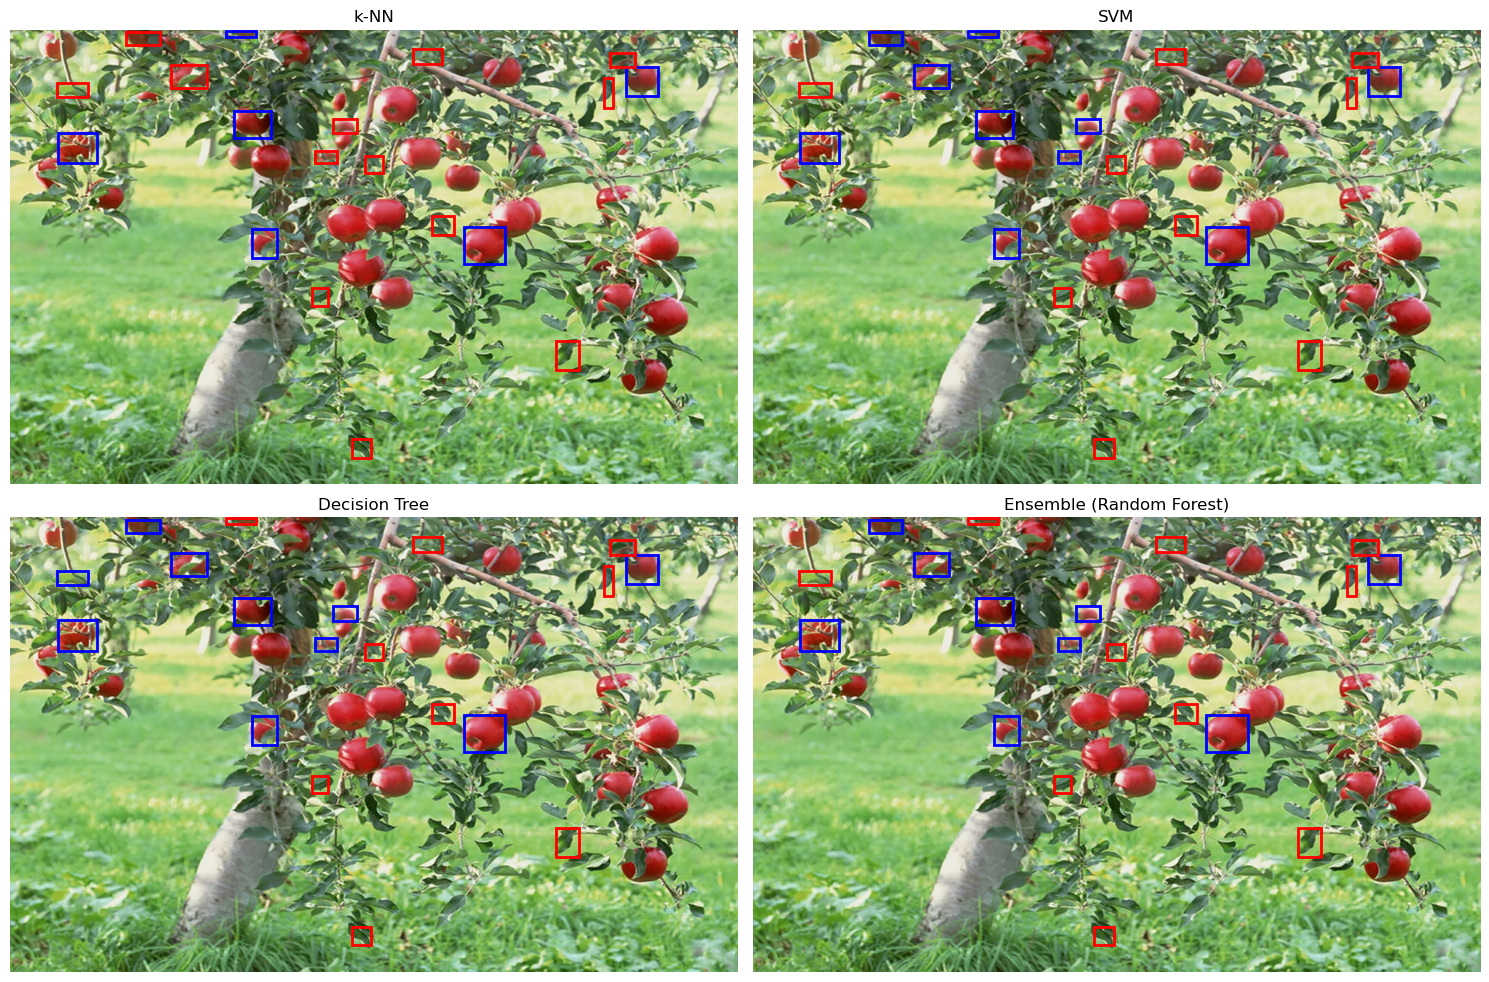

In [71]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, (model_name, y_pred) in enumerate(predictions.items()):
    ax = axes[idx]
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for (xmin, ymin, xmax, ymax), pred in zip(boxes_test, y_pred):
        color = 'blue' if pred == 1 else 'red'
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, edgecolor=color, facecolor='none', linewidth=2)
        ax.add_patch(rect)
        label = '' if pred == 1 else ''
        ax.text(xmin, ymin - 10, label, color=color, fontsize=12, weight='bold')
    ax.set_title(model_name)
    ax.axis('off')

plt.tight_layout()
plt.show()